In [1]:
import os
import sys
%cd ..
from tqdm.auto import tqdm
import numpy as np
import time
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output
from joblib import Parallel, delayed
from utils import pkl2csv
from sklearn import metrics
from joblib import Parallel, delayed
import glob


/sise/liorrk-group/OrDanOfir/lior.exp.4


# load one csv by Filtering_Algorithm and datsets_num

In [2]:
Filtering_Algorithm = 'FWDT'
datsets_num = 20
topk=[1,2,3,4,5,10,15,20,25,30,50,100]
df = pkl2csv(Filtering_Algorithm,datsets_num,path = 'temp',topk=topk)

# Load all csv's to one dataframe file

In [3]:
def load_all_datasets(topk,path = 'temp'):
    df0 = []
    df1 = []
    score = []
    names = []
    algo = ['FWDT','RFE_SVM','f_classif','reliefF','STG','new_STG','new_FWDT','ensemble','mrmr']
    for f in tqdm(algo):
        df = Parallel(n_jobs=int(64))(delayed(pkl2csv)(f,d,path = 'temp',topk=topk) for d in range(63))
        df0 = df0 + df
    df0 = pd.concat(df0)
    return df0

# Load all aug best csv's to one dataframe file

In [4]:
def load_one_best(row):
    Filtering_Algorithm = row.split("/")[1]
    datsets_num = None
    path = row.split("/")[0]
    name = row.split("/")[-1].split("_")[0]
    df = pkl2csv(Filtering_Algorithm,datsets_num,path,name)
    return df
def load_all_datasets_best(paths):
    df0 = Parallel(n_jobs=int(64))(delayed(load_one_best)(row) for row in tqdm(paths))
    df0 = pd.concat(df0)
    return df0

In [5]:
if not os.path.exists("temp/results_best.csv"):
    paths = glob.glob("temp/aug*/*.pickle")
    df2 = load_all_datasets_best(paths)
    df2.to_csv("temp/results_best.csv",index=False)
else:
    df2 = pd.read_csv("temp/results_best.csv")

print("load best")

if not os.path.exists("temp/results.csv"):
    df = load_all_datasets(topk,path = 'temp')
    df.to_csv("temp/results.csv",index=False)
else:
    df = pd.read_csv("temp/results.csv")
    
print("load real")    

df_all = pd.concat([df,df2])
if not os.path.exists("temp/results_all.csv"):
    df.to_csv("temp/results_all.csv",index=False)

load best
load real


# Comparison All Feature Selection methods

  0%|          | 0/62 [00:00<?, ?it/s]

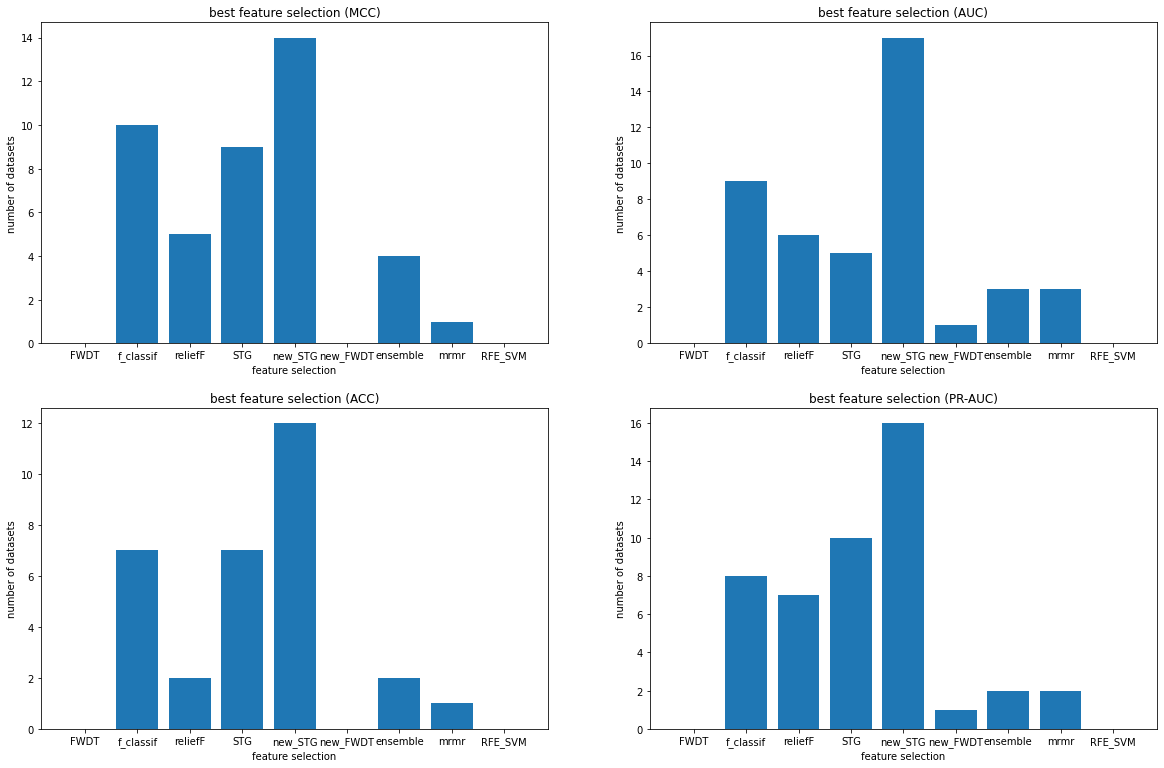

In [6]:
algo = ['FWDT','f_classif','reliefF','STG','new_STG','new_FWDT','ensemble','mrmr','RFE_SVM']
datasets = []
best = []
m = []
df_mini = df[df['Fold']=="CV Score"]
for i,mini in tqdm(df_mini.groupby("Dataset Name")):
    # in_data = list(set(mini['Filtering Algorithm']))
    # # print(in_data)
    # stop = False
    # for in_d in algo:
    #     # print(in_d)
    #     if in_d not in in_data:
    #         # print(in_d)
    #         stop = True
    # if stop:
    #     continue
    for j,mini2 in mini.groupby("Measure Type"):
        if len(mini2[mini2['Measure Value'] == mini2['Measure Value'].max()]['Filtering Algorithm'].values) > 1:
            # print("more")
            continue
        best.append(mini2[mini2['Measure Value'] == mini2['Measure Value'].max()]['Filtering Algorithm'].values[0])
        m.append(j)
        datasets.append(i)
# plt.figure(figsize=(16, 8)) 
f,ax = plt.subplots(2,2,figsize=(20,13))
for index,mm in enumerate(list(set(m))):
    datasets = np.array(datasets)
    best = np.array(best)
    m = np.array(m)
    metric = np.where(m == mm)[0]
    d = datasets[metric]
    b = best[metric]
    s = [len(b[np.where(b==bb)[0]]) for bb in algo]
    ax[index//2][index%2].bar(algo,s)
    ax[index//2][index%2].set_title(f"best feature selection ({mm})")
    ax[index//2][index%2].set_xlabel('feature selection')
    ax[index//2][index%2].set_ylabel('number of datasets')
plt.show()

In [7]:
algo = ['FWDT','f_classif','reliefF','STG','new_STG','new_FWDT','ensemble','mrmr','RFE_SVM']
datasets = []
best = []
m = []
df_mini = df[df['Fold']=="CV Score"]
rank_acc = {"MCC": {'FWDT':[],'f_classif':[],'reliefF':[],'STG':[],'new_STG':[],'new_FWDT':[],'ensemble':[],'mrmr':[],'RFE_SVM':[]},
            "AUC": {'FWDT':[],'f_classif':[],'reliefF':[],'STG':[],'new_STG':[],'new_FWDT':[],'ensemble':[],'mrmr':[],'RFE_SVM':[]},
            "ACC": {'FWDT':[],'f_classif':[],'reliefF':[],'STG':[],'new_STG':[],'new_FWDT':[],'ensemble':[],'mrmr':[],'RFE_SVM':[]},
            "PR-AUC": {'FWDT':[],'f_classif':[],'reliefF':[],'STG':[],'new_STG':[],'new_FWDT':[],'ensemble':[],'mrmr':[],'RFE_SVM':[]},}
for i,mini in tqdm(df_mini.groupby("Dataset Name")):
    in_data = list(set(mini['Filtering Algorithm']))
    # print(in_data)
    stop = False
    for in_d in algo:
        # print(in_d)
        if in_d not in in_data:
            # print(in_d)
            stop = True
    if stop:
        continue
    for j,mini2 in mini.groupby("Measure Type"):
        if len(mini2[mini2['Measure Value'] == mini2['Measure Value'].max()]['Filtering Algorithm'].values) > 1:
            continue
        df_ = mini2.sort_values('Measure Value').drop_duplicates("Filtering Algorithm",keep='last')
        df_['rank'] = df_["Measure Value"].rank()
        for s,row in df_.iterrows():
            rank_acc[j][row['Filtering Algorithm']].append(row['rank'])

  0%|          | 0/62 [00:00<?, ?it/s]

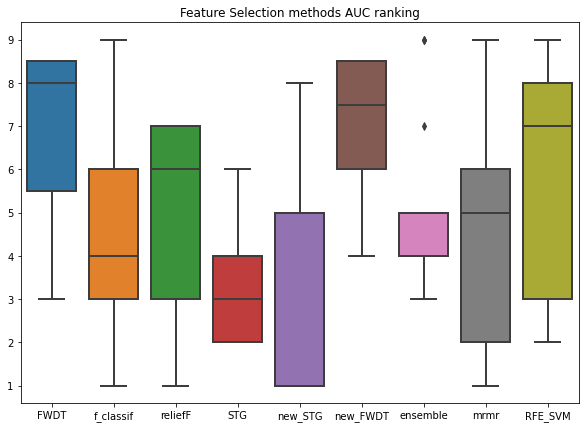

In [8]:
import seaborn as sns
data = np.zeros([len(rank_acc['AUC'].keys()),len(rank_acc['AUC']['FWDT'])])
for i,key in enumerate(rank_acc['AUC'].keys()):
    data[i] = rank_acc['AUC'][key]
green_diamond = dict(markerfacecolor='g', marker='D')
fig = plt.figure(figsize =(10, 7))
# data = data / data.max()
data = 10-data
# Creating plot
sns.boxplot(data=data.T,linewidth=2)
# plt.boxplot(data.T,flierprops=green_diamond)
plt.xticks(range(0,len(algo)),algo)
# show plot
plt.title("Feature Selection methods AUC ranking")
plt.show()

In [9]:
def show_best(ax,algo = ['new_STG','STG'],metric='ACC',k=None):
    datasets = []
    best = []
    m = []
    df_mini = df[df['Fold']=="CV Score"]
    for i,mini in tqdm(df_mini.groupby("Dataset Name")):
        in_data = list(set(mini['Filtering Algorithm']))
        # print(in_data)
        stop = False
        for in_d in algo:
            # print(in_d)
            if in_d not in in_data:
                # print(in_d)
                stop = True
        if stop:
            continue
        if k is not None and str(k) != 'best':
            mini = mini[mini['Number of features selected (K)'] ==k]
        mini = mini[mini['Measure Type']==metric]
        df0 = mini[mini['Filtering Algorithm']==algo[0]]
        df1 = mini[mini['Filtering Algorithm']==algo[1]]
        res = df0['Measure Value'].max() - df1['Measure Value'].max() 
        best.append(res)
        m.append(j)
        datasets.append(i)
    res = np.array(best)
    names = [n.split(".csv")[0][0:7] for n in datasets]
    names = np.array(names)
    index = np.argsort(res)[::-1]
    names,res = names[index],res[index]
    index2 = np.where(res>0)[0]
    index1 = np.where(res<=0)[0]
    ax.bar(names[index2],res[index2])
    ax.bar(names[index1],res[index1])
    ax.xaxis.set_tick_params(which='both', rotation=90)
    ax.set_title(f"Show the improve: {algo[0]} vs {algo[1]} ({metric} = {round(np.mean(res),5)}) features selected (K) = {k}", fontsize=20)

# Show the improve STG

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

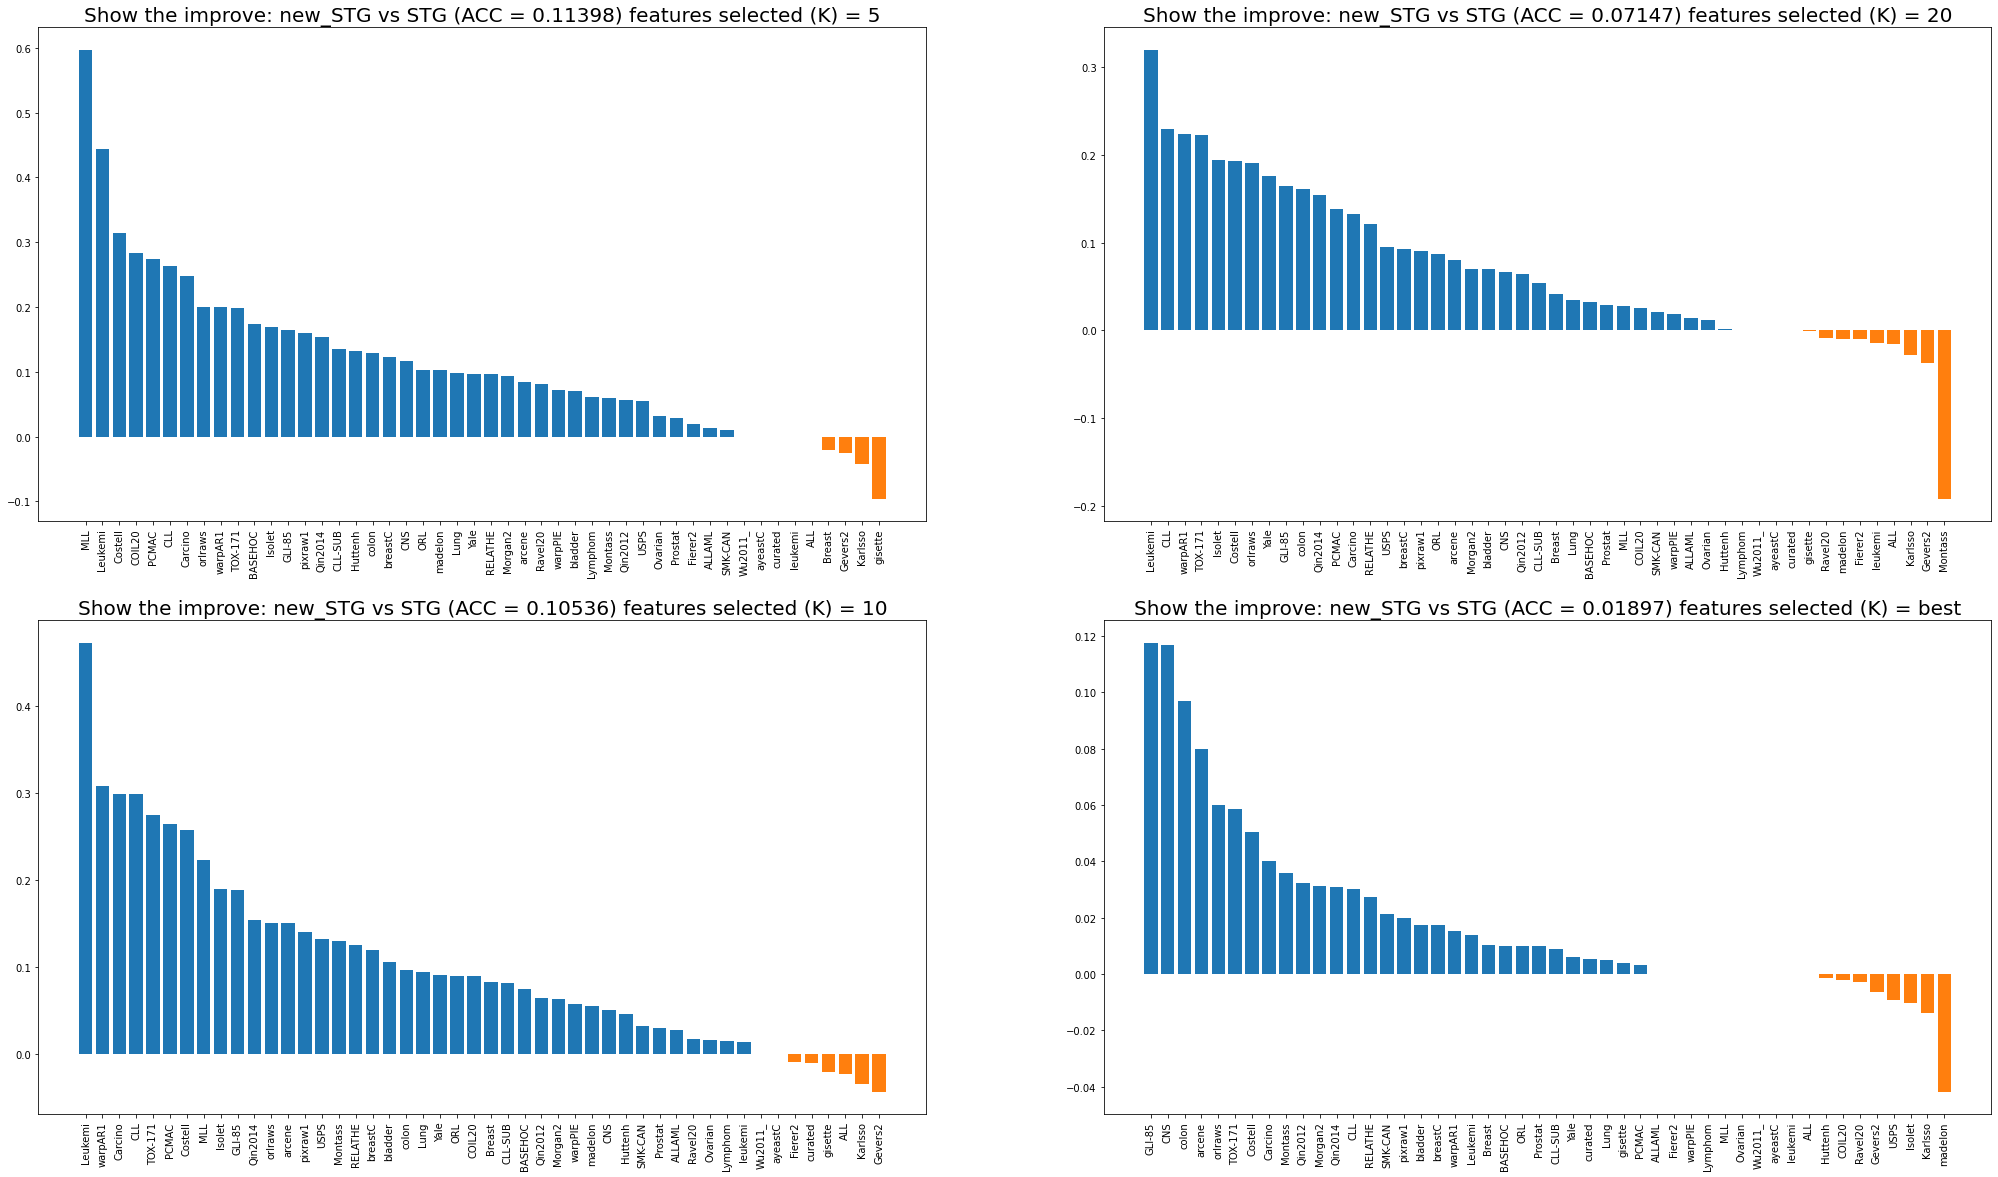

In [10]:
fig,ax = plt.subplots(2,2,figsize=(35,20))
show_best(ax[0][0],algo = ['new_STG','STG'],metric='ACC',k=5)
show_best(ax[1][0],algo = ['new_STG','STG'],metric='ACC',k=10)
show_best(ax[0][1],algo = ['new_STG','STG'],metric='ACC',k=20)
show_best(ax[1][1],algo = ['new_STG','STG'],metric='ACC',k='best')
plt.savefig("STG.png")

# Show the improve FWDT

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

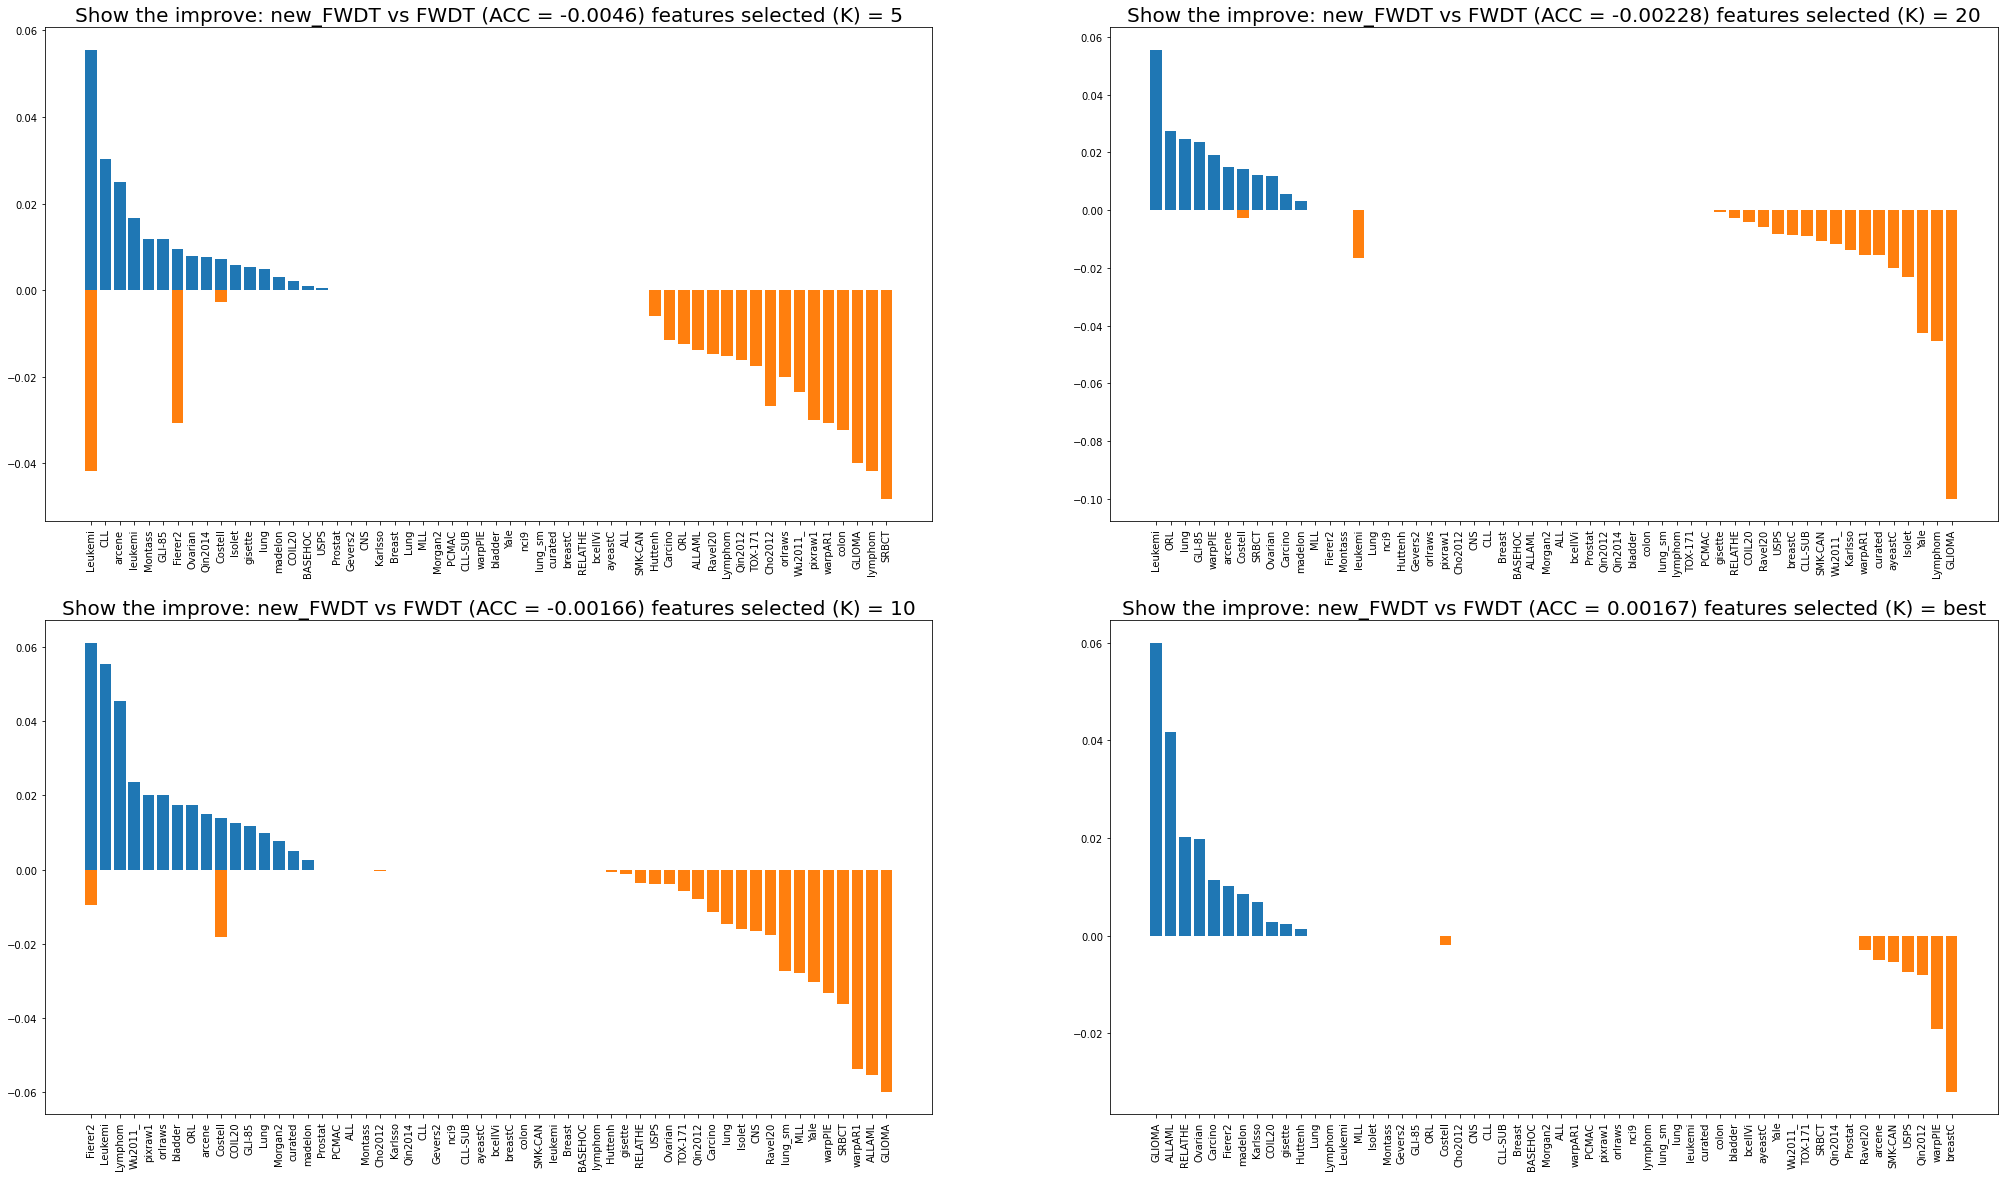

In [11]:
fig,ax = plt.subplots(2,2,figsize=(35,20))
show_best(ax[0][0],algo = ['new_FWDT','FWDT'],metric='ACC',k=5)
show_best(ax[1][0],algo = ['new_FWDT','FWDT'],metric='ACC',k=10)
show_best(ax[0][1],algo = ['new_FWDT','FWDT'],metric='ACC',k=20)
show_best(ax[1][1],algo = ['new_FWDT','FWDT'],metric='ACC',k='best')
plt.savefig("FWDT.png")

# Comparison learning algorithm

In [12]:
Filtering_Algorithm = 'STG'
datsets_num = 0
topk=[1,2,3,4,5,10,15,20,25,30,50,100]
df_mini = pkl2csv(Filtering_Algorithm,datsets_num,path = 'temp',topk=topk)

In [13]:
# Filtering_Algorithm = 'STG'
# datsets_num = 4
# topk=[1,2,3,4,5,10,15,20,25,30,50,100]
# df_mini = pkl2csv(Filtering_Algorithm,datsets_num,path = 'temp',topk=topk)
# plt.figure(figsize=[20,15])
# metric = 'AUC'
# z = 0
# name = history_summary_old['Dataset Name'].values[0]
# for t,history_fold in df_mini.groupby("Fold"):
#     z+=1
#     plt.subplot(3,4,z)
#     for i,mini_df in history_fold.groupby("Learning algorithm"):
#         mini_df = mini_df.sort_values("Number of features selected (K)")
#         mini_df = mini_df.set_index("Number of features selected (K)")
#         mini_df = mini_df[mini_df['Measure Type']==metric]
#         plt.plot(mini_df[['Measure Value']],label=i,marker='o')
#     plt.xlabel(r'Number of features selected (K)', fontsize=10)
#     # plt.ylabel(f'{metric}', fontsize=10)
#     plt.title(f"datasets {name} - fold: {t} - {metric}")
#     plt.legend()
# plt.show()

# Comparison of filtering algorithm on CV Score with best learning algorithm

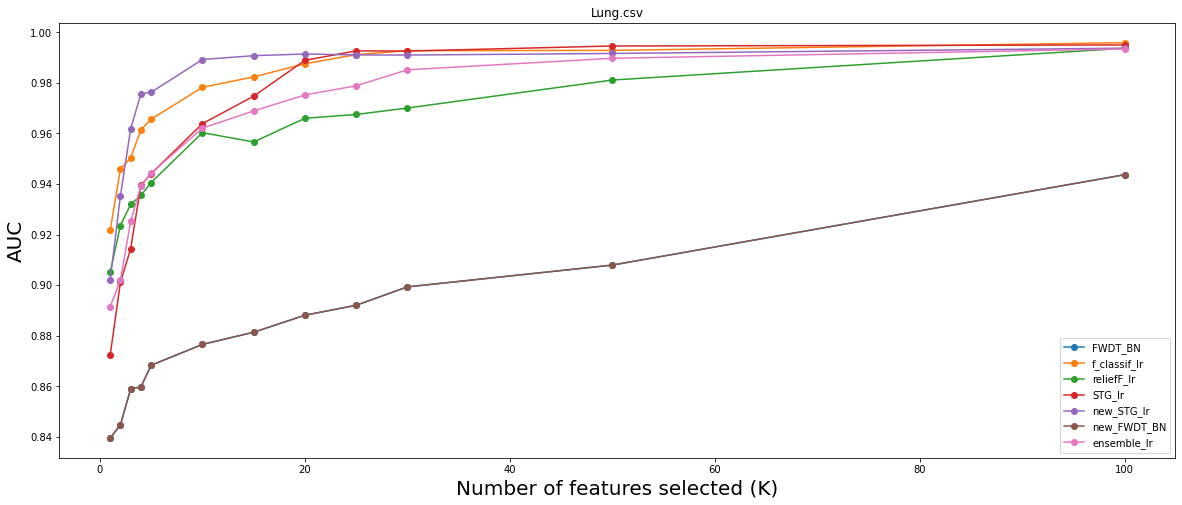

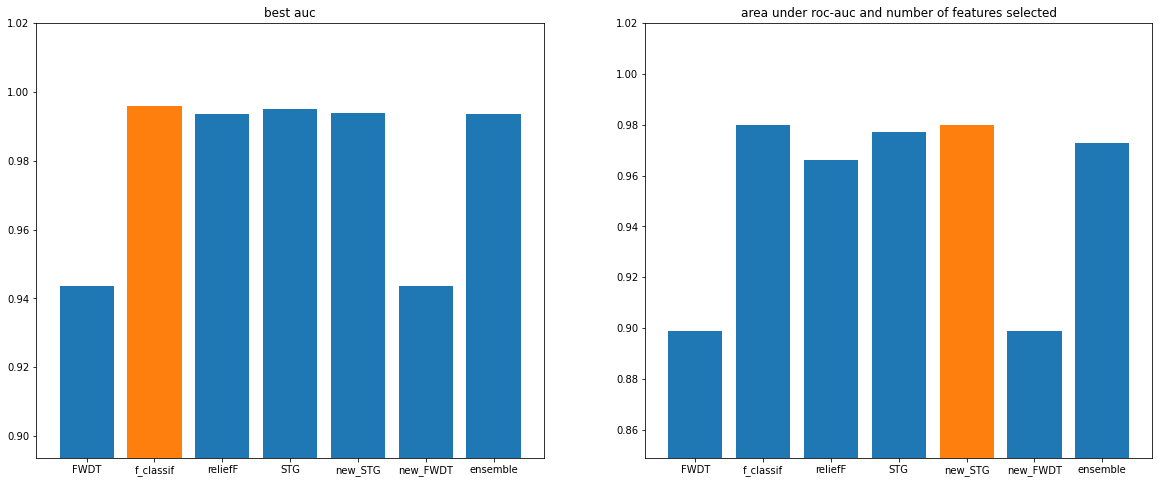

In [14]:
d = ['FWDT','RFE_SVM','f_classif','reliefF','STG','new_STG','mrmr','new_FWDT','ensemble']

metric = 'AUC'
bars = []
names = []
auc = []
for datsets_num in range(4,5):
    plt.figure(figsize=[20,8])
# datsets_num =2
    for row in d:
        try:
            history_summary_old = pkl2csv(row,datsets_num,path = 'temp',topk=topk)
            history_summary_old = history_summary_old[history_summary_old['Fold']=='CV Score']
            history_summary_old = history_summary_old[history_summary_old['Measure Type']==metric]
            best = list(history_summary_old[history_summary_old['Measure Value'] == history_summary_old['Measure Value'].max()]["Learning algorithm"])[0]
            history_summary_old = history_summary_old[history_summary_old['Learning algorithm'] == best]
            bars.append(float(history_summary_old[['Measure Value']].max()))
            names.append(row)
            for i,mini_df in history_summary_old.groupby("Learning algorithm"):
                mini_df = mini_df.sort_values("Number of features selected (K)")
                mini_df = mini_df.set_index("Number of features selected (K)")
                mini_df = mini_df[mini_df['Measure Type']==metric]
                auc.append(metrics.auc(np.array(list(mini_df.index))/100,np.array(list(mini_df['Measure Value']))))
                plt.plot(mini_df[['Measure Value']],label=f'{row}_{i}',marker='o')
        except:
            pass
    try:
        plt.legend()
        plt.ylabel(f'{metric}', fontsize=20)
        name = history_summary_old['Dataset Name'].values[0]
        plt.title(name)
        plt.xlabel(r'Number of features selected (K)', fontsize=20)
        plt.savefig(f"{name}.png")
    except:
        pass
plt.show()
plt.figure(figsize=[20,8])
plt.subplot(121)
plt.bar(names,bars)
m = np.max(bars)
index = list(np.where(bars==m)[0])
bars = np.array(bars)
names = np.array(names)
plt.bar(names[index],bars[index])
plt.ylim(np.min(bars)-0.05,1.02)
plt.title("best auc")
plt.subplot(122)
plt.bar(names,auc)
m = np.max(auc)
index = list(np.where(auc==m)[0])
auc = np.array(auc)
names = np.array(names)
plt.bar(names[index],auc[index])
plt.ylim(np.min(auc)-0.05,1.02)
plt.title("area under roc-auc and number of features selected")
plt.show()

# Show the improve using aug (PCA + GAN)

In [15]:
if not os.path.exists("temp/results_best.csv"):
    paths = glob.glob("temp/aug*/*.pickle")
    df2 = load_all_datasets_best(paths)
    df2.to_csv("temp/results_best.csv",index=False)
else:
    df2 = pd.read_csv("temp/results_best.csv")

print("load best")

if not os.path.exists("temp/results.csv"):
    df = load_all_datasets(topk,path = 'temp')
    df.to_csv("temp/results.csv",index=False)
else:
    df = pd.read_csv("temp/results.csv")
    
print("load real")    

df_all = pd.concat([df,df2])
if not os.path.exists("temp/results_all.csv"):
    df.to_csv("temp/results_all.csv",index=False)

load best
load real


In [16]:
df2 = df2[df2['Fold']=='CV Score']
df2 = df2[df2['Filtering Algorithm'] !='aug']
res = []
names = []
for name,mini_df in tqdm(df2.groupby("Dataset Name")):
    try:
        LA = mini_df['Learning algorithm'].values[0]
        FS = mini_df['Filtering Algorithm'].values[0].split("aug_")[1]
        K = mini_df['Number of features selected (K)'].values[0]
        mini2 = df[df['Dataset Name'] == name]
        mini2 = mini2[mini2['Fold']=='CV Score']
        mini3 = mini2[mini2['Learning algorithm']==LA]
        mini3 = mini3[mini3['Filtering Algorithm']==FS]
        mini3 = mini3[mini3['Number of features selected (K)']==K]
        res.append(mini_df['Measure Value'].values - mini3['Measure Value'].values)
        names.append(name)
    except:
        pass

  0%|          | 0/37 [00:00<?, ?it/s]

In [17]:
mini_df

,Dataset Name,Number of samples,Original Number of features,Filtering Algorithm,Learning algorithm,Number of features selected (K),CV Method,Fold,CV folds split,List of Selected Features Names (Long STRING),Selected Features scores,Measure Type,Measure Value,Learning algorithm train time,Learning algorithm predict proba time,Filtering algorithm time
836,warpPIE10P.csv,210,2421,aug_RFE_SVM,lr,100,Folds CV10,CV Score,10,['feature_409' 'feature_226' 'feature_119' 'fe...,[1. 0.99958661 0.99917321 0.99875982 0...,ACC,1.0,5.312865,0.005375,676.775308
837,warpPIE10P.csv,210,2421,aug_RFE_SVM,lr,100,Folds CV10,CV Score,10,['feature_409' 'feature_226' 'feature_119' 'fe...,[1. 0.99958661 0.99917321 0.99875982 0...,MCC,1.0,5.312865,0.005375,676.775308
838,warpPIE10P.csv,210,2421,aug_RFE_SVM,lr,100,Folds CV10,CV Score,10,['feature_409' 'feature_226' 'feature_119' 'fe...,[1. 0.99958661 0.99917321 0.99875982 0...,AUC,1.0,5.312865,0.005375,676.775308
839,warpPIE10P.csv,210,2421,aug_RFE_SVM,lr,100,Folds CV10,CV Score,10,['feature_409' 'feature_226' 'feature_119' 'fe...,[1. 0.99958661 0.99917321 0.99875982 0...,PR-AUC,1.0,5.312865,0.005375,676.775308


In [18]:
metric = ["ACC","MCC","AUC","PR-AUC"]

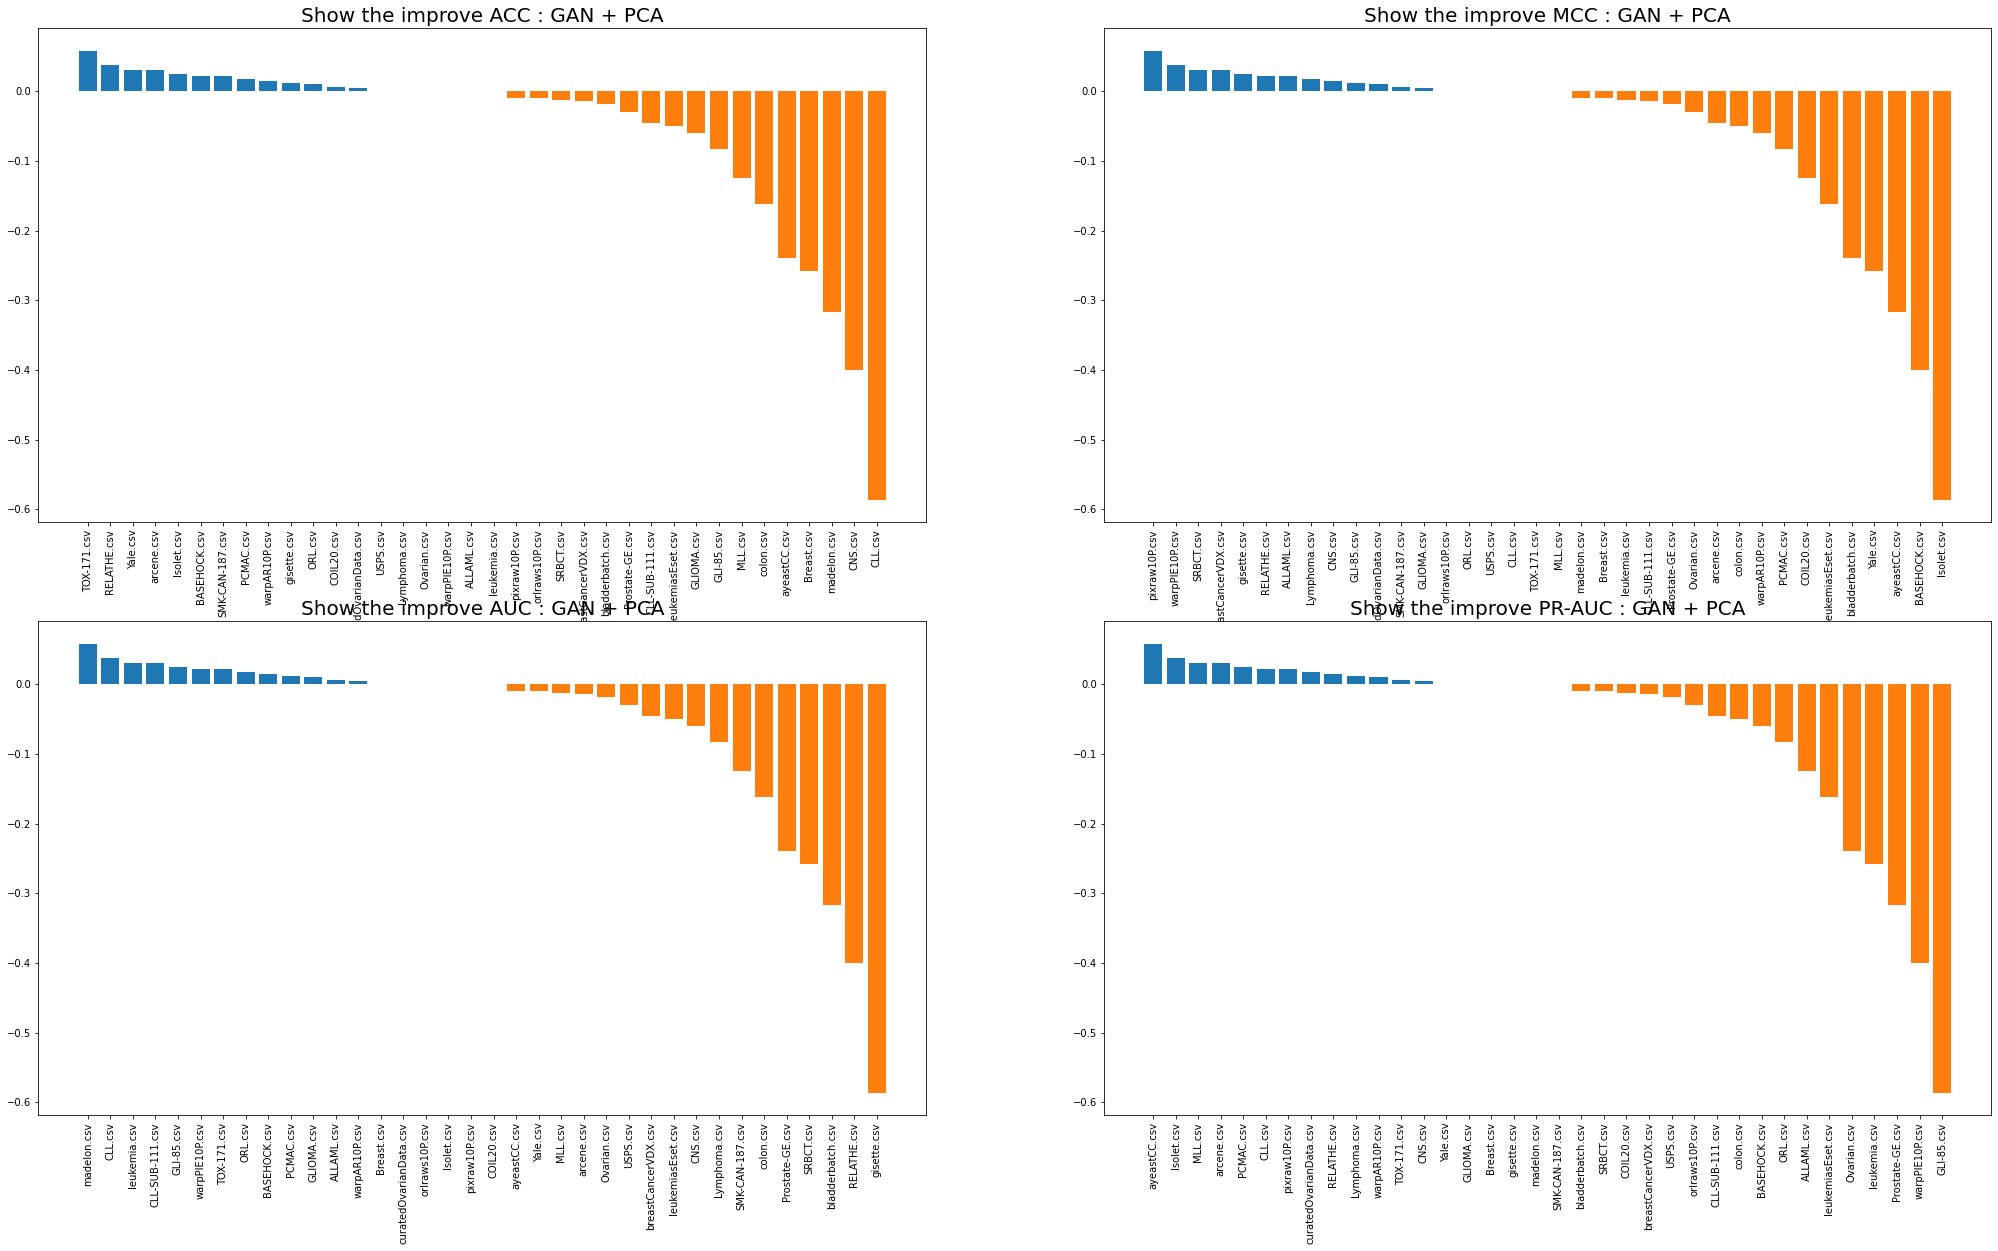

In [19]:
fig,axs = plt.subplots(2,2,figsize=(35,20))
for index in range(4):
    m = metric[index]
    ax = axs[index//2,index%2]
    res2 = np.array(res)[:,0]
    names = np.array(names)
    index = np.argsort(res2)[::-1]
    names,res2 = names[index],res2[index]
    index2 = np.where(res2>0)[0]
    index1 = np.where(res2<=0)[0]
    ax.bar(names[index2],res2[index2])
    ax.bar(names[index1],res2[index1])
    ax.xaxis.set_tick_params(which='both', rotation=90)
    ax.set_title(f"Show the improve {m} : GAN + PCA" , fontsize=20)
plt.savefig("pca_aug_gan.png")

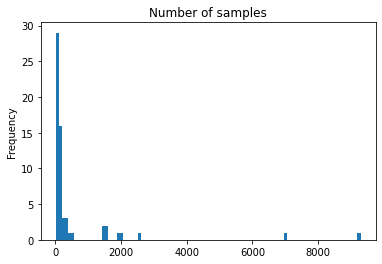

Text(0.5, 1.0, 'Original Number of features')

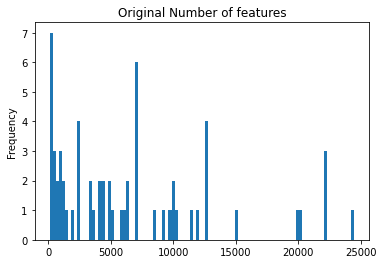

In [20]:
df.drop_duplicates("Dataset Name")['Number of samples'].plot.hist(bins=100)
plt.title('Number of samples')
plt.show()
df.drop_duplicates("Dataset Name")['Original Number of features'].plot.hist(bins=100)
plt.title('Original Number of features')

In [21]:
df.drop_duplicates(["Dataset Name","Filtering Algorithm"]).value_counts("Filtering Algorithm")

Filtering Algorithm
FWDT         62
f_classif    62
new_FWDT     62
reliefF      62
STG          61
ensemble     58
new_STG      51
RFE_SVM      43
mrmr         37
dtype: int64